In [1]:
import pandas as pd
import nltk
import re
import multiprocessing
import gensim
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords

In [2]:
data = pd.read_csv('hotel-reviews.csv')

In [3]:
reviews = data['Description']

In [4]:
reviews

0        The room was kind of clean but had a VERY stro...
1        I stayed at the Crown Plaza April -- - April -...
2        I booked this hotel through Hotwire at the low...
3        Stayed here with husband and sons on the way t...
4        My girlfriends and I stayed here to celebrate ...
                               ...                        
38927    We arrived late at night and walked in to a ch...
38928    The only positive impression is location and p...
38929    Traveling with friends for shopping and a show...
38930    The experience was just ok. We paid extra for ...
38931    The Westin is a wonderfully restored grande da...
Name: Description, Length: 38932, dtype: object

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmtm1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmtm1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
stopwords_en = stopwords.words('english')
print(stopwords_en)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
def clean_data(text):
    text = re.sub(r'[^A-Za-z0-9\s.]',r'',str(text).lower())
    text = re.sub(r'\n',r' ',text)
    return " ".join([word for word in text.split() if word not in stopwords_en])

In [21]:
clean_reviews = [clean_data(review) for review in reviews]
clean_reviews[0]

'room kind clean strong smell dogs. generally average ok overnight stay youre fussy. would consider staying price right. breakfast free better nothing.'

In [9]:
nltk.sent_tokenize(clean_reviews[0], 'english')

['room kind clean strong smell dogs.',
 'generally average ok overnight stay youre fussy.',
 'would consider staying price right.',
 'breakfast free better nothing.']

In [10]:
with open('tokenized_sentences.txt', 'w', encoding='utf-8') as file:
    for review in clean_reviews:
        for sentence in nltk.sent_tokenize(review, 'english'):
            print(sentence, file=file)

In [11]:
data = gensim.models.word2vec.LineSentence('tokenized_sentences.txt')
model = Word2Vec(data, size=300, window=5, min_count=2, workers=multiprocessing.cpu_count())

In [12]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [13]:
words = []
embeddings = []
for word in list(model.wv.vocab):
    embeddings.append(model.wv[word])
    words.append(word)
    
tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
print('TSNE done')
embeddings_2d = tsne_2d.fit_transform(embeddings)
print('Embeddings done')

TSNE done
Embeddings done


Scatter done
Annotate done


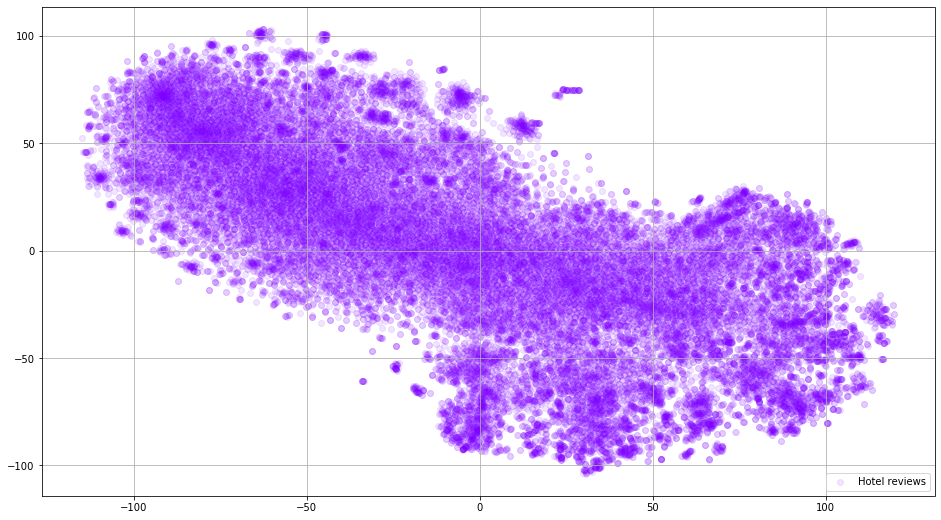

In [14]:
def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    print('Scatter done')
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    print('Annotate done')
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_2d('Hotel reviews', embeddings_2d, a=0.1)

In [16]:
keys = ['good', 'bad', 'bathroom', 'family', 'bar', 'restaurant', 'beach', 'pay', 'dirty']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

C:\Users\mmtm1\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\Users\mmtm1\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [18]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_2d_keys = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d_keys = np.array(tsne_model_2d_keys.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

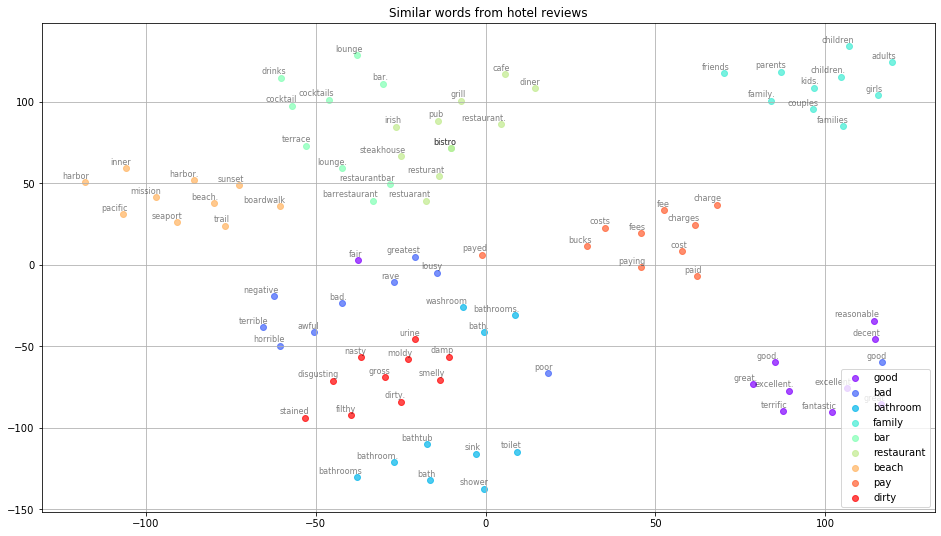

In [20]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.show()


tsne_plot_similar_words('Similar words from hotel reviews', keys, embeddings_2d_keys, word_clusters, 0.7)